# Melenoma Detection
Eeshan Gupta | eeshangpt@gmail.com

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Table of Content

1. [Problem Statement](#Problem-Statement)
2. [Data Reading and Dataset Creation](#Data-Reading-and-Dataset-Creation)
3. [Data Visualizations](#Data-Visualizations)
4. [Model Building and Training](#Model-Building-and-Training)
    1. [Building the model]()
    1. [Training Model]()
    1. [Visualizing Training Results]()
5. [Data Augmentation](#Data-Augmentation)
    1. [Augmentation Model]()
    1. [Training Model]()
    1. [Visualizing Training Results]()
6. [Handling Class Imbalance](#Handling-Class-Imbalance)
    1. [Finding imbalance]()
    1. [Augmenting dataset]()
    1. [Creating dataset]()
    1. [Model building, training and Visualizations]()

## Data Reading and Dataset Creation

**Imports and standard setup**

In [1]:
!pip install Augmentor

In [2]:
from collections import Counter
from glob import glob
from os import getcwd
from os.path import basename, dirname, join
from pathlib import Path

import Augmentor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory

2023-12-06 03:51:09.269463: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
PRJ_DIR = getcwd()
DATA_DIR = join(PRJ_DIR, 'data')

In [4]:
data_dir_train = Path(join(DATA_DIR, 'Train'))
data_dir_test = Path(join(DATA_DIR, 'Test'))

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Creating Dataset

**Defining loading parameters**

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=123,
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size,)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


2023-12-06 03:51:11.162754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 03:51:11.167698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 03:51:11.167972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
val_ds = image_dataset_from_directory(data_dir_train,
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=123,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size,)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [9]:
test_ds = image_dataset_from_directory(data_dir_test, seed=123,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size,)

Found 118 files belonging to 9 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualizations

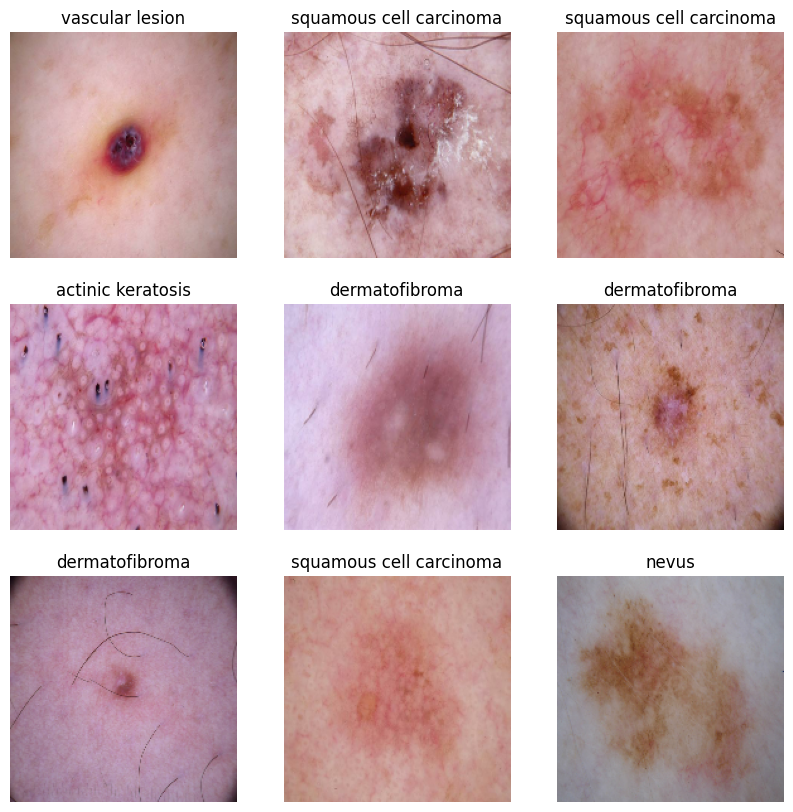

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Building and Training

### Building the model

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Model Training

In [16]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


2023-12-06 03:51:20.675334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-12-06 03:51:20.983438: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0c56d7440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 03:51:20.983461: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-12-06 03:51:20.988149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 03:51:21.159903: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 [==============================] - 17s 27ms/step - loss: 1.7719 - accuracy: 0.3124 - val_loss: 1.4430 - val_accuracy: 0.4749
Epoch 2/20
281/281 [==============================] - 6s 20ms/step - loss: 1.3349 - accuracy: 0.4974 - val_loss: 1.3447 - val_accuracy: 0.5207
Epoch 3/20
281/281 [==============================] - 5s 19ms/step - loss: 1.0940 - accuracy: 0.6016 - val_loss: 1.0555 - val_accuracy: 0.6293
Epoch 4/20
281/281 [==============================] - 5s 19ms/step - loss: 0.8315 - accuracy: 0.7024 - val_loss: 0.7976 - val_accuracy: 0.7121
Epoch 5/20
281/281 [==============================] - 5s 19ms/step - loss: 0.6008 - accuracy: 0.7859 - val_loss: 0.6335 - val_accuracy: 0.7583
Epoch 6/20
281/281 [==============================] - 5s 19ms/step - loss: 0.4464 - accuracy: 0.8415 - val_loss: 0.4653 - val_accuracy: 0.8456
Epoch 7/20
281/281 [==============================] - 5s 19ms/step - loss: 0.3215 - accuracy: 0.8853 - val_loss: 0.4297 - val_accuracy: 0.8652
Epoch 8/2

### Visualizing Training Results

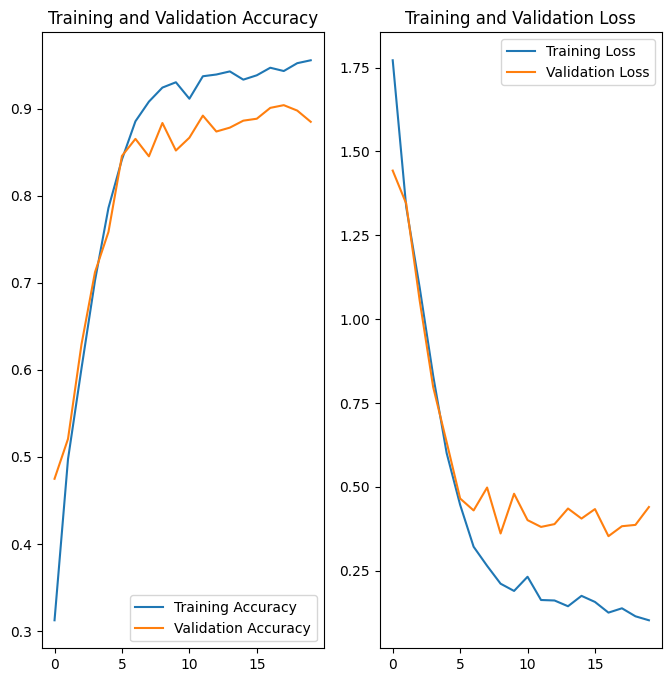

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**

- The training accuracy is higher as compared to the validation accuracy
- The training loss is lower than validation loss
- The model seems to overfit

## Data Augmentation

### Augmentation model

In [18]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                 input_shape=(img_height,
                                                              img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),])

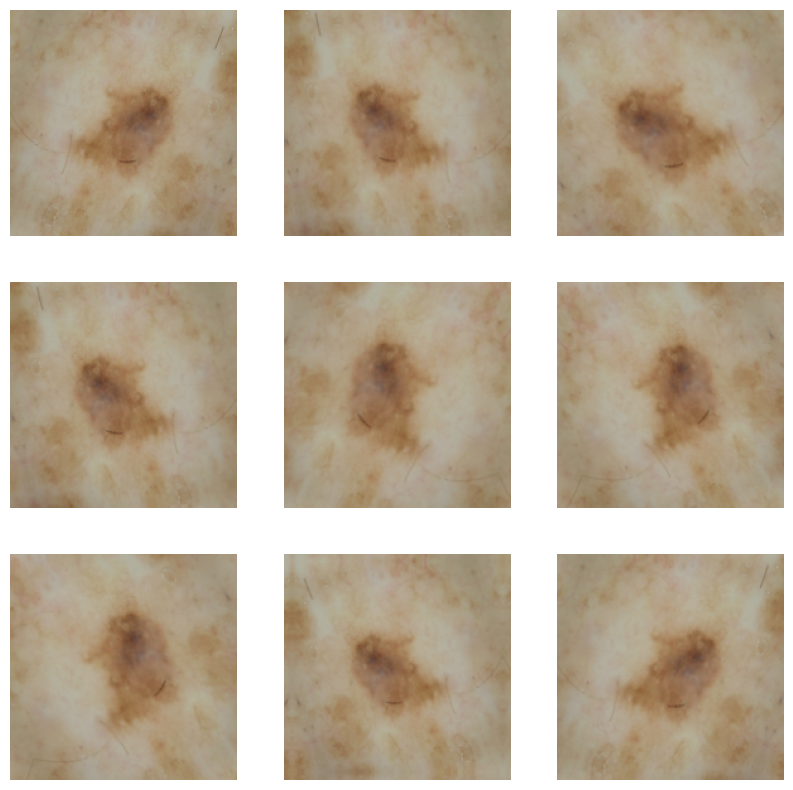

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building

In [20]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names)),
])

In [21]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [23]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


2023-12-06 03:53:15.117939: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


281/281 [==============================] - 10s 31ms/step - loss: 1.7192 - accuracy: 0.3362 - val_loss: 1.4971 - val_accuracy: 0.4201
Epoch 2/20
281/281 [==============================] - 9s 31ms/step - loss: 1.4175 - accuracy: 0.4507 - val_loss: 1.2784 - val_accuracy: 0.5305
Epoch 3/20
281/281 [==============================] - 9s 31ms/step - loss: 1.2971 - accuracy: 0.5002 - val_loss: 1.3087 - val_accuracy: 0.5069
Epoch 4/20
281/281 [==============================] - 9s 31ms/step - loss: 1.2151 - accuracy: 0.5368 - val_loss: 1.1234 - val_accuracy: 0.5763
Epoch 5/20
281/281 [==============================] - 9s 31ms/step - loss: 1.1376 - accuracy: 0.5657 - val_loss: 1.0703 - val_accuracy: 0.5897
Epoch 6/20
281/281 [==============================] - 9s 31ms/step - loss: 1.0466 - accuracy: 0.6030 - val_loss: 1.0331 - val_accuracy: 0.6106
Epoch 7/20
281/281 [==============================] - 9s 31ms/step - loss: 1.0168 - accuracy: 0.6163 - val_loss: 0.8803 - val_accuracy: 0.6702
Epoch 8/2

### Visualizing the training results

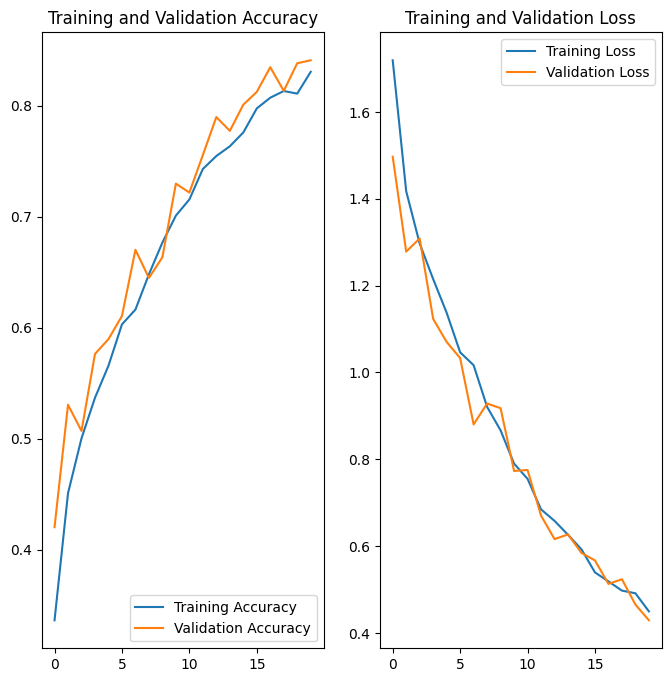

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**

- The overfitting of the model has decresed and the accuracy and loss for validation almost follows the pattern of training
- This is an improvement

## Handling Class Imbalance

### Finding the inbalance among classes

In [25]:
path_list = [x for x in glob(join(data_dir_train, '*', '*.jpg'))]
lesion_list = [basename(dirname(y)) for y in glob(join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/workspace/Project/data/Train/pigmented benign...,pigmented benign keratosis
1,/workspace/Project/data/Train/pigmented benign...,pigmented benign keratosis
2,/workspace/Project/data/Train/pigmented benign...,pigmented benign keratosis
3,/workspace/Project/data/Train/pigmented benign...,pigmented benign keratosis
4,/workspace/Project/data/Train/pigmented benign...,pigmented benign keratosis
...,...,...
2234,/workspace/Project/data/Train/basal cell carci...,basal cell carcinoma
2235,/workspace/Project/data/Train/basal cell carci...,basal cell carcinoma
2236,/workspace/Project/data/Train/basal cell carci...,basal cell carcinoma
2237,/workspace/Project/data/Train/basal cell carci...,basal cell carcinoma


Class=5, n=462 (20.634%)
Class=0, n=114 (5.092%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=1, n=376 (16.793%)


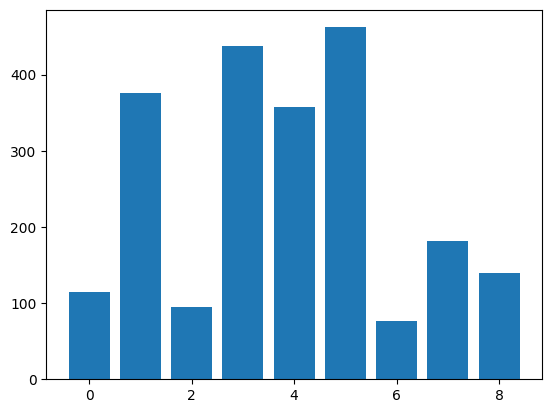

In [26]:
X, y = original_df['Path'], original_df['Label']
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

In [27]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### Augmenting the datasets

In [28]:
path_to_training_dataset = join(DATA_DIR, 'Train') + '/'

In [29]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /workspace/Project/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4104EF1F0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 182.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /workspace/Project/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD41056F3D0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 180.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /workspace/Project/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4106FC0D0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 191.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /workspace/Project/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD4281AF580>: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /workspace/Project/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4104EDF00>: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 45.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /workspace/Project/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD428382080>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 209.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /workspace/Project/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD4284C46A0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /workspace/Project/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD428383010>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 222.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /workspace/Project/data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD41053CB20>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 205.37 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


In [31]:
path_list_new = [x for x in glob(join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [basename(dirname(dirname(y)))
                   for y in glob(join(data_dir_train, '*', 'output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

/tmp/ipykernel_10411/1602488648.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

### Creating the dataset

In [32]:
train_ds = image_dataset_from_directory(data_dir_train, seed=123,
                                        validation_split = 0.2,
                                        subset = 'training',
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [33]:
val_ds = image_dataset_from_directory(data_dir_train, seed=123,
                                      validation_split = 0.2,
                                      subset = 'validation',
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [34]:
test_ds = image_dataset_from_directory(data_dir_test,
                                       image_size=(img_height, img_width),
                                       batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model creation, training, and visualizations

In [36]:
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(len(class_names))
                   ])

In [37]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20


2023-12-06 03:56:58.252679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-06 03:57:08.343484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 314 of 1000
2023-12-06 03:57:11.381579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


394/394 [==============================] - 29s 37ms/step - loss: 1.6062 - accuracy: 0.3705 - val_loss: 1.4016 - val_accuracy: 0.4639
Epoch 2/20
394/394 [==============================] - 11s 29ms/step - loss: 1.1106 - accuracy: 0.5906 - val_loss: 0.9663 - val_accuracy: 0.6409
Epoch 3/20
394/394 [==============================] - 11s 29ms/step - loss: 0.7253 - accuracy: 0.7425 - val_loss: 0.6004 - val_accuracy: 0.7903
Epoch 4/20
394/394 [==============================] - 11s 29ms/step - loss: 0.4930 - accuracy: 0.8252 - val_loss: 0.5237 - val_accuracy: 0.8208
Epoch 5/20
394/394 [==============================] - 12s 29ms/step - loss: 0.3445 - accuracy: 0.8754 - val_loss: 0.3818 - val_accuracy: 0.8770
Epoch 6/20
394/394 [==============================] - 12s 29ms/step - loss: 0.2570 - accuracy: 0.9079 - val_loss: 0.3718 - val_accuracy: 0.8786
Epoch 7/20
394/394 [==============================] - 12s 30ms/step - loss: 0.2400 - accuracy: 0.9136 - val_loss: 0.5020 - val_accuracy: 0.8437
Epo

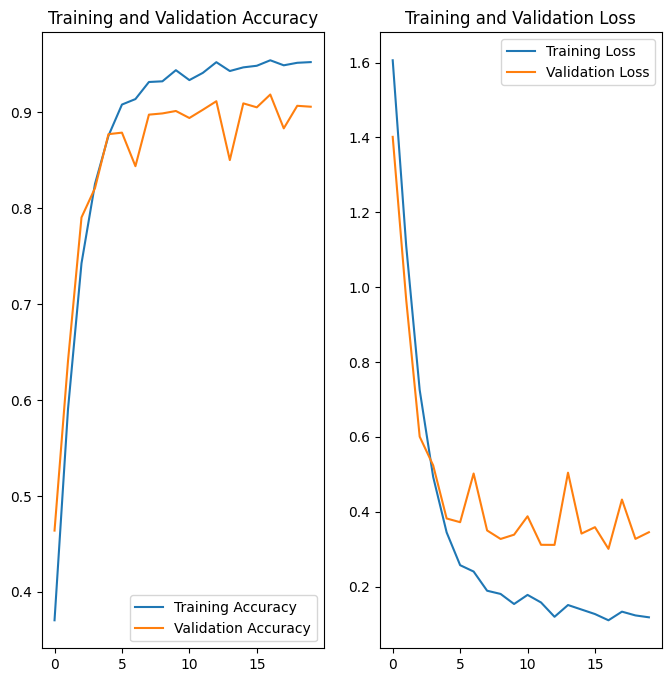

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result Analysis**  
The overfitting reduced. It is evident from the accuracy and loss curves. This is a result of class rebalancing.